# 0. Get Setup (Import libraries & functions)

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Import torch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
try:
  from tochinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary
try:
  from torch.utils.tensorboard import SummaryWriter
except:
  !pip install tensorboard
  from torch.utils.tensorboard import SummaryWriter

# import extra packages
from tqdm.auto import tqdm
import os
import requests
import zipfile
from pathlib import Path

In [2]:
# Import personal modular PyTorch scripts created in chapter 5 from GitHub
!git clone https://github.com/axeleichelmann/learn_pytorch_course
!mv learn_pytorch_course/modular_pytorch .
!rm -rf learn_pytorch_course
from modular_pytorch import data_setup, utils, engine

Cloning into 'learn_pytorch_course'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 84 (delta 35), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 11.39 MiB | 5.78 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [3]:
# Set up device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on {device}...")

Working on cuda...


# 1. Import data

In [4]:
# Create directory in which to store image data
data_path = Path("data/")
img_path = data_path / "pizza_steak_sushi"

if data_path.is_dir():
  print(f"Directory {data_path} already exists...")
else:
  print(f"Creating directory {data_path}...")
  data_path.mkdir(parents=True, exist_ok=True)

# Import image dat zipfile from GitHub
github_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get(github_url)
  print(f"Importing image data zip file form GitHub...")
  f.write(request.content)

# Unzip image data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zipref:
  print(f"Unzipping image data into {img_path}...")
  zipref.extractall(img_path)

# Remove zip file from data directory
os.remove(data_path / "pizza_steak_sushi.zip")

Creating directory data...
Importing image data zip file form GitHub...
Unzipping image data into data/pizza_steak_sushi...


# 2. Create DataLoaders

Images in dataloader will be 224x224 in accordance with the ViT Paper (https://arxiv.org/abs/2010.11929), & we will stick with a batch size of 8 (as opposed to 4096 as was used in the ViT paper) due to our compute power being much less than that which wis used in the research.


In [5]:
# Define training & testing directories
train_dir = img_path / "train"
test_dir = img_path / "test"

# Define transformer for ViT Model
std_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

# Create dataloaders
BATCH_SIZE = 8
NUM_WORKERS = 0

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir,
                                                                               train_transform= std_transform, test_transform=std_transform,
                                                                               batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

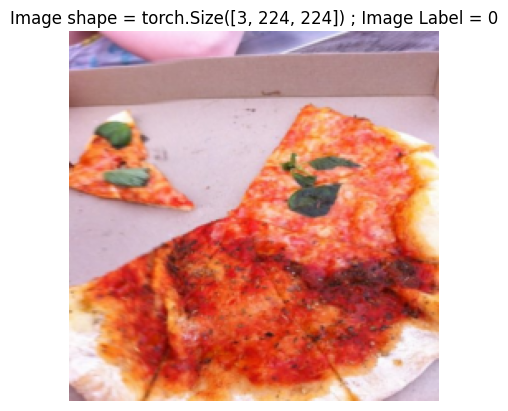

In [6]:
# Visulaise a single image from the training dataloader
img_batch, label_batch = next(iter(train_dataloader))

plt.imshow(img_batch[0].permute(1,2,0))
plt.title(f"Image shape = {img_batch[0].shape} ; Image Label = {label_batch[0]}")
plt.axis(False)
plt.show()

# 3. Replicating the ViT Architecture

## 3.1.1 Recreating Eq. 1 - Creating Patch Embeddings

In [7]:
# Calculate number of patches required given image data
height, width, color_channels = 224, 224, 3    # Define input image dimensions
patch_size = 16    # Define size of patches that we'll split input image into
N = int((height*width)/(patch_size**2))    # Calculate number of patches into which the image will be split
D = 768    # Embedding dimension throughout the architecture - set to 768 in accordance with ViT-Base's embedding dimensions

print(f"The input image will have dimensions (H,W,C) = ({height,width,color_channels}), and we will split it into {N} patches of size ({patch_size}x{patch_size}*{color_channels})")
print(f"These patches will then be flattened thus the input to the embedding layer will have shape: {N}x{patch_size*patch_size*color_channels}")
print(f"We will then linearly project these inputs into {D} dimensions in the embedding layer, thus the output of the embedding layer (i.e. the embedded patches) will have shape {N}x{D}")

# Create patch emebdding - turn image into a sequence of patches & then embed those patches
import PIL
from torchvision import transforms

def patch_embedding(image : PIL.Image, transform : transforms.Compose,
                    image_size : int, patch_size : int):
  """
  Takes PIL image and splits it into patches of size (path_size x patch_size x color_channnels).
  """

  # Make sure the overall image size is divisible by the patch size
  assert image_size % patch_size == 0, "'image_size' must be a multiple of 'path size'"

  transformed_image = transform(image).permute(1,2,0)

  N_h = int(transformed_image.shape[0]/patch_size)
  N_w = int(transformed_image.shape[1]/patch_size)

  patches = []

  for h in range(N_h):
    for w in range(N_w):
      patch = transformed_image[h*patch_size : (h+1)*patch_size, w*patch_size : (w+1)*patch_size, : ]
      patches.append(patch)

  return patches

The input image will have dimensions (H,W,C) = ((224, 224, 3)), and we will split it into 196 patches of size (16x16*3)
These patches will then be flattened thus the input to the embedding layer will have shape: 196x768
We will then linearly project these inputs into 768 dimensions in the embedding layer, thus the output of the embedding layer (i.e. the embedded patches) will have shape 196x768


Importing image of Mikey Muscemeci eating pizza


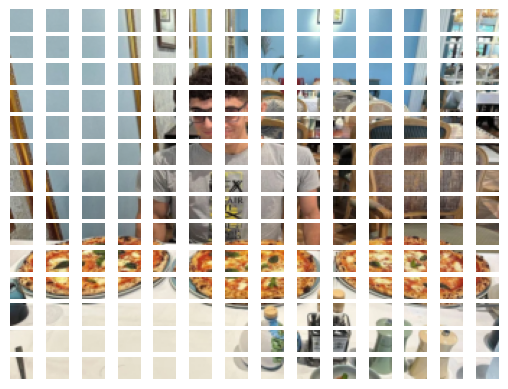

In [8]:
### Test Patch Creator Function

# Import image of Mikey Muscemeci eating pizza
from pathlib import Path
import requests

data_path = Path("data/")
data_path.mkdir(parents=True, exist_ok=True)

github_url = "https://github.com/axeleichelmann/learn_pytorch_course/raw/main/data/mikey_muscemeci_pizza.jpg"
with open(data_path / "mikey_muscemeci_pizza.jpg", "wb") as f:
  request = requests.get(github_url)
  print(f"Importing image of Mikey Muscemeci eating pizza")
  f.write(request.content)

custom_img_path = data_path / "mikey_muscemeci_pizza.jpg"
custom_img = PIL.Image.open(custom_img_path)

# Create transformer for image
std_transform = transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor()
                                    ])

# Embed custom_img into patches
patches = patch_embedding(image=custom_img, transform = std_transform,
                          image_size=224, patch_size=16)

# Plot patches
import matplotlib.pyplot as plt

plt.figure()
for i, patch in enumerate(patches):
  plt.subplot(14,14,i+1)
  plt.imshow(patch)
  plt.axis(False)
plt.show()

In [9]:
# Alternatively Use Conv2d with kenrel_size & stride = patch size
patch_size=16

conv2d = nn.Conv2d(in_channels=3, out_channels=768,
                   kernel_size=patch_size, stride=patch_size)
conv_output = conv2d(std_transform(custom_img).unsqueeze(0))

flatten = nn.Flatten(start_dim=2, end_dim=3)
flatten_output = flatten(conv_output)

conv_output.shape, flatten_output.shape

(torch.Size([1, 768, 14, 14]), torch.Size([1, 768, 196]))

In [10]:
# Create patch embedding model
class PatchEmbedding_ViT(nn.Module):
  """
  Turns a 2D input into a 1D sequence of learnable embedding vectors for the Vision Transformer Architecture.
  -----------------------
  Args:
  input_channels - the number of color channels of the input image
  patch_size - height & width of patches that the image will be split into (default = 16 in accordance with Base ViT Architecture)
  embedding_dim - size of embedding vector to turn image into (default = 768 in accordance with Base ViT Architecture - assuming image w/ 3 color channels & patch size of 16)
  """
  def __init__(self, input_channels : int=3, patch_size : int=16, hidden_size : int=768):
    super().__init__()

    self.conv_layer = nn.Conv2d(in_channels=input_channels, out_channels=hidden_size,
                           kernel_size=patch_size, stride=patch_size)

    self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)


  def forward(self, x):
    image_res = x.shape[-1]
    assert image_res % patch_size == 0, f"Image height and width must be a multiplt of `patch_size` - image shape = {image_res}, patch_size = {patch_size}"
    return self.flatten_layer(self.conv_layer(x)).permute(0,2,1)

# Create instance of patch embedding
patch_embedder = PatchEmbedding_ViT(input_channels=3, patch_size=16, hidden_size=768)
patch_embedding = patch_embedder(std_transform(custom_img).unsqueeze(0))

## 3.1.2 Recreating Eq. 1 - Creating Class Token & Position Embeddings

We want to create an embedding of the class token to prepend to the patch embedding, thus we need to create a parameter whose dimension is equal to the hidden embedding dimension (i.e. a 1x768 tensor).

We will do this using the `nn.Parameter` and `torch.randn` functions.

For the position embedding we will need to create a parameter with dimensions 197x768 which will be added to the class & patch embedding parameter.

In [11]:
# Create class token parameter which acts as a learnable embedding of the class token
hidden_size = 768
class_token = nn.Parameter(torch.randn([1,1,hidden_size]),
                           requires_grad=True)

# Concat patch embedding with class embedding
patch_and_class_embedding = torch.cat([class_token, patch_embedding], dim=1)


In [12]:
# Create position parameter which acts as a learnable embedding of the patch positions
image_height, image_width = 224, 224
patch_size = 16
N = image_height*image_width/patch_size**2
position_embedding = torch.randn([1, int(N+1), hidden_size],
                                 requires_grad=True)

# Add position embedding to patch embedding to get full embedding before transformer
pre_transformer_embedding = patch_and_class_embedding + position_embedding

## 3.1.3 Recreating Eq.1. - Creating Full Pre-Transformer Embedding in a Single Code Cell

In [13]:
# Begin by defining the image size, patch size, embedding dimension, and calculating N = Number of Patches,
INPUT_CHANNELS = 3
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

PATCH_SIZE = 16
N_PATCHES = IMAGE_HEIGHT*IMAGE_WIDTH/PATCH_SIZE**2

EMBEDDING_DIM = INPUT_CHANNELS*PATCH_SIZE**2

# Create transformer that will be used to resize & turn images into tensors before passing them into ViT Transformer
std_transformer = transforms.Compose([
                                      transforms.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
                                      transforms.ToTensor()
                                    ])

# Create Patch Embedding
patch_embedder = PatchEmbedding_ViT(input_channels=INPUT_CHANNELS, patch_size=PATCH_SIZE, hidden_size=EMBEDDING_DIM)
patch_embedding = patch_embedder(std_transform(custom_img).unsqueeze(0))

# Create class token embedding
class_embedding = nn.Parameter(torch.randn([1, 1, EMBEDDING_DIM]), requires_grad=True)
patch_and_class_embedding = torch.cat([class_embedding, patch_embedding], dim=1)
print(f"The class & patch embedding parameter has shape : {patch_and_class_embedding.shape}")
assert patch_and_class_embedding.shape[1] == N_PATCHES+1 and patch_and_class_embedding.shape[2] == EMBEDDING_DIM, f"[ERROR] The class & patch embedding parameter should have shape : {[N_PATCHES+1, EMBEDDING_DIM]}"

# Create Position Embedding & Final pre-transformer embedding
pos_embedding = nn.Parameter(torch.randn([1, int(N_PATCHES+1), EMBEDDING_DIM]))
pre_transformer_embedding = pos_embedding + patch_and_class_embedding
print(f"The final pre-transformer embedding parameter has shape : {pre_transformer_embedding.shape}")

The class & patch embedding parameter has shape : torch.Size([1, 197, 768])
The final pre-transformer embedding parameter has shape : torch.Size([1, 197, 768])


## 3.2 Recreating Eq.2. - LayerNorm & Multi-head Self-Attention (MSA)

In [14]:
# Create sub-model which replicates the first part of the transformer - Carries out Mulit-Self Attention & Layer Normalization
class MultiSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0):
    super().__init__()

    self.layernorm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.MSA = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads,
                                     dropout=attn_dropout, batch_first=True)

  def forward(self, x):
    ln_output = self.layernorm(x)
    attn_output, _ = self.MSA(query=ln_output, key=ln_output, value=ln_output, need_weights=False)   # Compute output of Equation 2 : z'= MSA(LN(z)) + z
    return attn_output + ln_output

In [15]:
# Test out MSA module
MSA = MultiSelfAttentionBlock(embedding_dim=EMBEDDING_DIM, num_heads=12, attn_dropout=0)
MSA_output = MSA(pre_transformer_embedding)

print(f"The output of the LayerNorm & Multi-head Self-Attention Block of the Transformer block has shape : {MSA_output.shape}")
MSA_output

The output of the LayerNorm & Multi-head Self-Attention Block of the Transformer block has shape : torch.Size([1, 197, 768])


tensor([[[-0.0857, -0.7147, -0.7780,  ..., -0.9597, -0.2411, -2.1475],
         [ 0.8755, -0.8003, -0.0635,  ..., -1.2987,  0.3604, -2.4409],
         [-1.3646, -0.7033,  1.1275,  ...,  1.8024, -1.0494,  0.2721],
         ...,
         [-1.1069,  0.7609,  1.2144,  ...,  1.4356,  1.1716, -2.8224],
         [-0.1705,  0.3892,  0.9446,  ...,  0.4394,  1.1556, -1.7226],
         [-1.5919, -1.6475,  0.3818,  ...,  0.1608,  3.3479, -0.0361]]],
       grad_fn=<AddBackward0>)

## 3.3. Recreating Eq.3. - LayerNorm & Multi-Layer Perceptron (MLP)

In [16]:
# Create module which replicates the MLP Block of the ViT Transfomere Layer - We will use
class MultiLayerPerceptron(nn.Module):
  def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout_prob:float=0.1):
    super().__init__()

    self.layernorm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp_layer = nn.Sequential(nn.Linear(in_features=embedding_dim, out_features=mlp_size),
                                   nn.GELU(),
                                   nn.Dropout(p=dropout_prob),
                                   nn.Linear(in_features=mlp_size, out_features=embedding_dim),
                                   nn.Dropout(p=dropout_prob))

  def forward(self, x):

    ln_output = self.layernorm(x)
    mlp_output = self.mlp_layer(ln_output)

    return mlp_output + x

In [17]:
# Test out MLP module
MLP = MultiLayerPerceptron(embedding_dim=EMBEDDING_DIM, mlp_size=3072, dropout_prob=0.1)
MLP_output = MLP(MSA_output)

print(f"The output of the Multi-Layer Perceptron Block of the Transformer has shape : {MLP_output.shape}")
MLP_output

The output of the Multi-Layer Perceptron Block of the Transformer has shape : torch.Size([1, 197, 768])


tensor([[[ 0.0558, -0.4625, -0.5687,  ..., -0.6865, -0.0283, -2.2016],
         [ 1.0201, -0.9914, -0.0071,  ..., -1.3571,  0.3195, -2.2287],
         [-1.5570, -0.7725,  1.2253,  ...,  1.8024, -1.0752,  0.3228],
         ...,
         [-0.7595,  0.7538,  1.0065,  ...,  1.4856,  1.0365, -3.0631],
         [-0.4530,  0.1762,  1.2844,  ...,  0.3957,  0.8698, -1.7541],
         [-1.3902, -1.7460,  0.4394,  ...,  0.0430,  3.2923, -0.0361]]],
       grad_fn=<AddBackward0>)

## 3.4. Recreating the Full Transformer Encoder - Combining MSA & MLP

In [18]:
# Create module which replicates the full transformer encoder by iterating through the MSA & MLP layers multiple times
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12, attn_dropout:float=0,
               mlp_size:int=3072, mlp_dropout:float=0.1):
    super().__init__()

    self.MSA_block = MultiSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
    self.MLP_block = MultiLayerPerceptron(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout_prob=mlp_dropout)

  def forward(self, x):
    x_prime = self.MSA_block(x)
    x = self.MLP_block(x_prime)
    return x

# Test out Transformer Encoder module
transformer_encoder = TransformerEncoder(embedding_dim=EMBEDDING_DIM,
                                        num_heads=12, attn_dropout=0,
                                        mlp_size=3072, mlp_dropout=0.1)

transformer_output = transformer_encoder(MLP_output)

print(f"The output of the entire transformer block (after iterating through the MSA & MLP layers a single time) has shape : {transformer_output.shape}")
transformer_output

The output of the entire transformer block (after iterating through the MSA & MLP layers a single time) has shape : torch.Size([1, 197, 768])


tensor([[[ 0.0081, -0.3775, -0.8242,  ..., -0.4952,  0.0888, -2.1130],
         [ 0.8492, -1.3055, -0.1999,  ..., -0.4104, -0.0316, -2.3027],
         [-1.4008, -1.1558,  0.7735,  ...,  2.1044, -1.1318,  0.8078],
         ...,
         [-1.0376,  0.7051,  0.8643,  ...,  1.7757,  1.2640, -3.2302],
         [-0.8146,  0.3924,  1.1437,  ...,  0.7399,  1.0910, -1.9636],
         [-1.5008, -1.7786,  0.3294,  ...,  0.3209,  3.3183, -0.4119]]],
       grad_fn=<AddBackward0>)

In [19]:
# Get summery of what happens when we pass an input of shape [1,197,768] through the Transformer Block
from torchinfo import summary
summary(model=transformer_encoder,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiSelfAttentionBlock (MSA_block)         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (MSA)               --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptron (MLP_block)            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_layer)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

In [20]:
# Create Transformer Block using `nn.TransformerEncoderLayer`
torch_transformer_encoder = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM,
                                                       nhead=12, dim_feedforward=3072,
                                                       dropout=0.1, activation="gelu",
                                                       batch_first=True, norm_first=True)

summary(model=torch_transformer_encoder,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 3.5. Creating Full ViT Architecture

In [21]:
# Create class which replicates the entire ViT Architecture
class ViT_Model(nn.Module):
  def __init__(self, num_classes:int,
               image_size:int=224, image_channels:int=3, patch_size:int=16, embedding_dim:int=768, embedding_dropout:float=0.1,   # Patch, Class & Position Embeddings
               num_heads:int=12, attn_dropout:float=0,   # MSA Block Parameters
               mlp_size:int=3072, mlp_dropout:float=0.1,
               n_transformer_layers:int=12):    # MLP Block Parameters
    super().__init__()


    self.n_patches = (image_size/patch_size)**2

    # Create patch, class, and position embeddings
    self.patch_embedder = PatchEmbedding_ViT(input_channels=image_channels, patch_size=patch_size, hidden_size=embedding_dim)

    self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)
    self.position_embedding = nn.Parameter(torch.randn(1, int(self.n_patches+1), embedding_dim), requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create Transformer Block & Layers
    self.transformer_block = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=mlp_size,
                                                        dropout=mlp_dropout, activation="gelu",
                                                        batch_first=True, norm_first=True)

    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=self.transformer_block, num_layers=n_transformer_layers)

    # Create classifier layer - Equation 4
    self.classifier = nn.Sequential(
                                    nn.LayerNorm(normalized_shape=embedding_dim),
                                    nn.Linear(in_features=embedding_dim, out_features=num_classes)
                                    )

  def forward(self, x):
    batch_size = x.shape[0]

    class_embedding = self.class_embedding.expand(batch_size,-1,-1)

    patch_embedding = self.patch_embedder(x)   # Create patch embedding of image
    full_embedding = self.embedding_dropout(torch.cat([class_embedding, patch_embedding], dim=1) + self.position_embedding)   # Calculate final pre-transformer embedding (patch + class + position embedding)

    transformer_output = self.transformer_encoder(full_embedding)

    return self.classifier(transformer_output[:,0])

# Test out entire ViT module
input_image = std_transform(custom_img).unsqueeze(0).to(device)

vit_model = ViT_Model(num_classes=3).to(device)
vit_output_logit = vit_model(input_image)

vit_output_logit

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[ 0.3392, -0.4696, -0.4212]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [22]:
# Get torchinfo summary of the entire ViT Model
summary(model=vit_model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT_Model (ViT_Model)                              [32, 3, 224, 224]    [32, 3]              7,239,936            True
├─PatchEmbedding_ViT (patch_embedder)              [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv_layer)                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        

## 4. Train the ViT Model

NOTE: The code below will not run since google Colab does not have enough RAM available for non-premium users

In [23]:
# # Define optimizer & loss function using hyperparameters used in the ViT paper
# optimizer  = torch.optim.Adam(vit_model.parameters(),
#                               lr=0.001,
#                               betas=(0.9,0.999),
#                               weight_decay=0.3)

# loss_fn = nn.CrossEntropyLoss()

# # Train the model for 100 Epochs & Record Results using SummaryWriter
# NUM_EPOCHS = 10
# writer0 = SummaryWriter()

# train_loss, train_acc, test_loss, test_acc = engine.train_model_v2(model=vit_model, num_epochs=NUM_EPOCHS,
#                                                                    train_dataloader=train_dataloader, test_dataloader=test_dataloader,
#                                                                    device=device, optimizer=optimizer, loss_fn=loss_fn,
#                                                                    writer=writer0)

In [24]:
# # Plot Loss & Accuracy Curves of ViT Model
# plt.figure(figsize=(10,7))

# plt.subplot(1,2,1)
# plt.plot(train_loss, label="Training Loss")
# plt.plot(test_loss, label="Testing Loss")
# plt.ylim(0,2)
# plt.title("Loss Curves")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(train_loss, label="Training Accuracy")
# plt.plot(test_loss, label="Testing Accuracy")
# plt.ylim(0,1)
# plt.title("Accuracy Curves")
# plt.legend()

# plt.show()

## Implementing Pretrained ViT Model from torchvision.models

Clearly the training of the ViT Model that we designed ourselves was not very good, and this is likely due to the major differences/limits in the training process that we implemented compared to what was done in the ViT Architecture paper such as:
- Much smaller training dataset (225 images vs. 1.3M - 303M images)
- No learning rate warmup (in the paper a learning rate warmup of 10,000 steps was used)
- Smaller Batch Size (We used a batch size of 8, the paper used 4096)

Unfortunately we cannot replicate the original training process that was used int he paper due to our limited hardware, thus we will instead import a pretrained version of the ViT Model from `torchvision.models`.

In [25]:
# Define weights & tranformer for ViT Model
import torchvision

weights = torchvision.models.ViT_B_16_Weights.DEFAULT
transformer = weights.transforms()

# Import ViT Model, redefine its classification layer & freeze everything except it's classification layer
vit_import = torchvision.models.vit_b_16(weights=weights).to(device)
for param in vit_import.parameters():
  param.requires_grad = False
vit_import.heads = nn.Sequential(nn.Linear(in_features=768, out_features=len(class_names)))

# Get torchinfo summary of imported ViT Model
summary(model=vit_import,
        input_size=(8,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224]     [8, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [8, 197, 768]        [8, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [8, 197, 768]        [8, 197, 768]        --                   --
│    └─Sequential (layers)                                   [8, 197, 768]        [8, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]        [8, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]        [8, 1

In [34]:
# Pass custom image through import ViT Model
custom_input_image = transformer(custom_img).unsqueeze(0).to(device)
print(f"Input Size : {input_image.shape}")

output_logits = vit_import(custom_input_image)
print(f"Output Size : {output_logits.shape}")
output_logits

Input Size : torch.Size([1, 3, 224, 224])
Output Size : torch.Size([1, 3])


tensor([[ 3.7978, -1.8960, -1.4833]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [27]:
# Define optimizer & loss function
optimizer = torch.optim.Adam(vit_import.parameters(),
                             lr=0.001,
                             betas=(0.9,0.999),
                             weight_decay=0.3)

loss_fn = nn.CrossEntropyLoss()

# Train imported ViT Model
NUM_EPOCHS = 10
writer1 = SummaryWriter(log_dir="runs/imported_ViT")

train_loss, train_acc, test_loss, test_acc = engine.train_model_v2(model=vit_import, num_epochs=NUM_EPOCHS,
                                                                   train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                                                                   optimizer=optimizer, device=device, loss_fn=loss_fn,
                                                                   writer=writer1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0 | Training Loss = 0.613, Training Accuracy = 0.79 | Evaluation Loss = 0.257, Evaluation Accuracy = 0.95


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1777: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


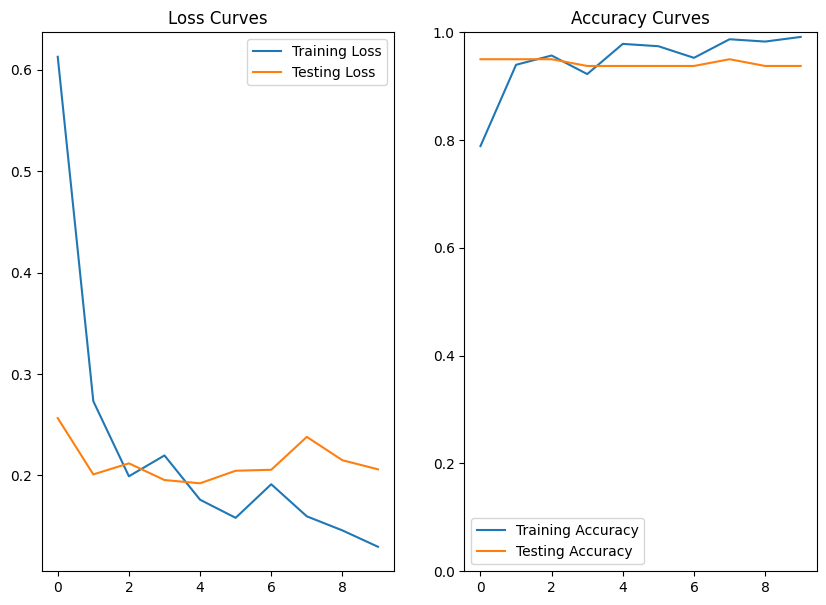

In [28]:
# Plot Loss & Accuracy Curves of ViT Model
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.plot(torch.stack(train_loss).detach().cpu(), label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Testing Accuracy")
plt.ylim(0,1)
plt.title("Accuracy Curves")
plt.legend()

plt.show()

In [29]:
# Save the model
utils.save_model(model=vit_import, save_dir=data_path / "saved_models", model_name="pretrained_ViT.pth")

# Calculate model size
vit_import_size = Path("data/saved_models/pretrained_ViT.pth").stat().st_size // (1024*1024)
print(f"The pretrained ViT model is {vit_import_size} MB")

[INFO] Saving model to data/saved_models/pretrained_ViT.pth
The pretrained ViT model is 327 MB


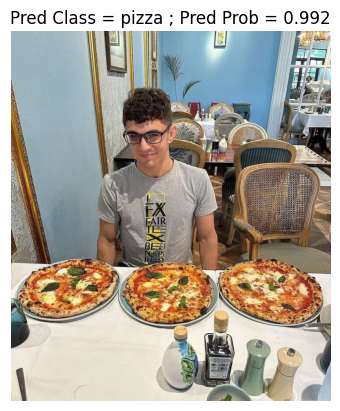

In [50]:
### Making predictions on the custom image of Mikey Muscemeci eating pizza using our pretrained ViT model
vit_import.eval()
with torch.inference_mode():
  pred_logits = vit_import(custom_input_image).cpu()
  pred_probs = pred_logits.softmax(dim=1)
  pred_class = pred_logits.argmax(dim=1)

plt.imshow(custom_img)
plt.title(f"Pred Class = {class_names[pred_class]} ; Pred Prob = {pred_probs.squeeze()[pred_class].item():.3f}")
plt.axis(False)
plt.show()